In [23]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.3/548.3 kB 6.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [26]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [9]:
spark = SparkSession.builder.appName("MySparkApp").getOrCreate()
spark

In [10]:
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/1513/pg1513.txt")
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/23042/pg23042.txt")
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/27761/pg27761.txt")
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/1533/pg1533.txt")
spark.sparkContext.addFile("https://www.gutenberg.org/cache/epub/1531/pg1531.txt")

In [12]:
df = spark.read.text(SparkFiles.getRootDirectory())
df.show()

+--------------------+
|               value|
+--------------------+
|The Project Guten...|
|                    |
|This ebook is for...|
|most other parts ...|
|whatsoever. You m...|
|of the Project Gu...|
|at www.gutenberg....|
|you will have to ...|
|before using this...|
|                    |
|Title: Hamlet, Pr...|
|                    |
|Author: William S...|
|                    |
|Editor: Charles J...|
|                    |
|Release date: Jan...|
|                M...|
|                    |
|   Language: English|
+--------------------+
only showing top 20 rows



In [13]:
# Breaking into series so it can be exploded to word per line
df = df.select(F.split(df.value, ' ').alias('sentence'))
df = df.select(F.explode(df.sentence).alias('word'))
df.show()

+---------+
|     word|
+---------+
|      The|
|  Project|
|Gutenberg|
|    eBook|
|       of|
|  Hamlet,|
|   Prince|
|       of|
|  Denmark|
|         |
|         |
|         |
|         |
|         |
|     This|
|    ebook|
|       is|
|      for|
|      the|
|      use|
+---------+
only showing top 20 rows



In [16]:
df = df.select(F.regexp_replace(df.word, r'[^\w\s]', '').alias('word'))

In [17]:
df.show()

+---------+
|     word|
+---------+
|      The|
|  Project|
|Gutenberg|
|    eBook|
|       of|
|   Hamlet|
|   Prince|
|       of|
|  Denmark|
|         |
|         |
|         |
|         |
|         |
|     This|
|    ebook|
|       is|
|      for|
|      the|
|      use|
+---------+
only showing top 20 rows



In [18]:
df = df.filter(df.word != '')

In [19]:
df.show()

+---------+
|     word|
+---------+
|      The|
|  Project|
|Gutenberg|
|    eBook|
|       of|
|   Hamlet|
|   Prince|
|       of|
|  Denmark|
|     This|
|    ebook|
|       is|
|      for|
|      the|
|      use|
|       of|
|   anyone|
| anywhere|
|       in|
|      the|
+---------+
only showing top 20 rows



In [20]:
print("number of rows:", df.count())

number of rows: 142666


In [21]:
df = df.groupBy(df.word).count().orderBy(F.desc('count'))
df.show()

+----+-----+
|word|count|
+----+-----+
| the| 4342|
| and| 2822|
|  of| 2775|
|   I| 2628|
|  to| 2594|
|   a| 2104|
| you| 1761|
|  in| 1694|
|  my| 1430|
|  is| 1337|
| not| 1233|
|that| 1145|
|with| 1123|
|  it| 1066|
|  me|  997|
|this|  993|
|  be|  928|
| And|  904|
| for|  800|
| his|  778|
+----+-----+
only showing top 20 rows



In [22]:
# convert spark dataFrame to Pandas DataFrame
df = df.toPandas()
df

,word,count
0,the,4342
1,and,2822
2,of,2775
3,I,2628
4,to,2594
...,...,...
16288,tiger,1
16289,foisons,1
16290,liveO,1
16291,chambers,1


In [24]:
# Create new DF with top 50 words
top_fifty = df.head(50)
top_fifty

,word,count
0,the,4342
1,and,2822
2,of,2775
3,I,2628
4,to,2594
5,a,2104
6,you,1761
7,in,1694
8,my,1430
9,is,1337


In [34]:
data = top_fifty.set_index('word').to_dict()['count']
wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)

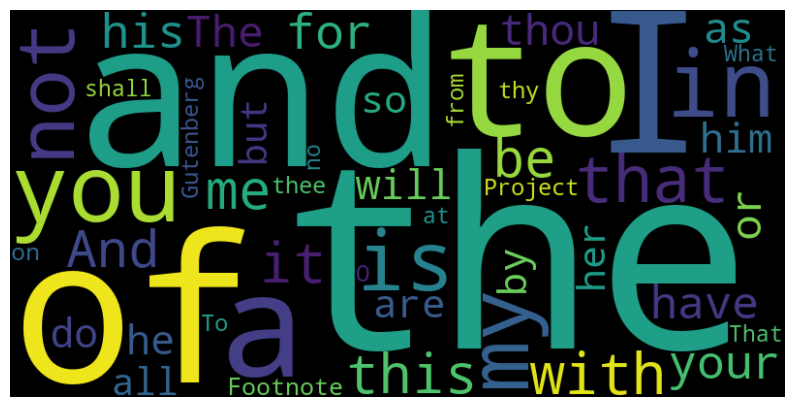

In [35]:
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: xlabel='count', ylabel='Count'>

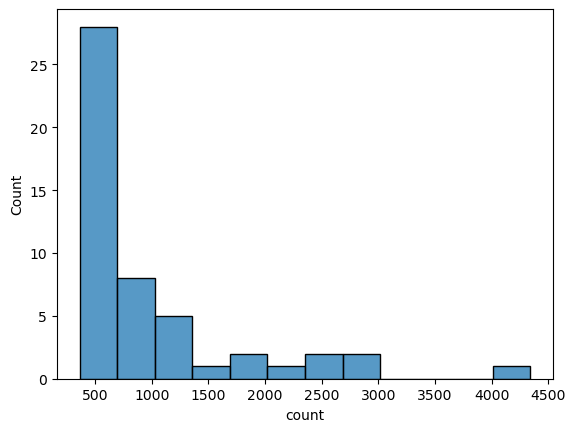

In [36]:
sns.histplot(top_fifty['count'])